## Convocatoria 1 - Proyecto 1

#### 0) Cargar una de las imágenes histológicas

De forma adicional a lo requerido en los enunciados del ejercicio, hemos considerado de interés verificar los resultados del análisis implementado. Para ello, hemos definido una variable (verificacion) que, en caso de ser True, hace que se cargue la imagen de verificación, cuyos resultados ya conocemos (vistos en clase).

In [1]:
verificacion = False

Introduzca el nombre de la imagen con su extensión (p.e. histo_1.jpg)

 histo_1.jpg


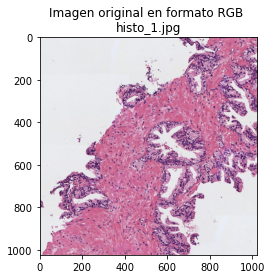

In [2]:
# Utilizar la librería skimage.io para leer la imagen 'histo_x.jpg' en formato RGB.
# Normalizar la imagen para que los píxeles se encuentren en el rango [0, 1]
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import cv2

if verificacion:
    img_name = 'figuras.png'
else:
    print('Introduzca el nombre de la imagen con su extensión (p.e. histo_1.jpg)', end='')
    img_name = input()

img = io.imread(img_name)
img_p = np.float32(img/255)

# Visualizar la imagen
plt.imshow(img_p)
plt.title('Imagen original en formato RGB \n' + img_name)
plt.show()

#### 1) Realizar una transformación de color para convertir la imagen al espacio de color CMYK

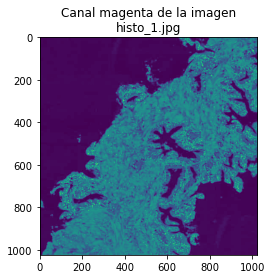

In [3]:
# Extraer la componente magenta de la imagen (que corresponde a la región tisular)
def convert_to_CMYK(rgb_norm):
    ''' Función que pasa una imagen de los colores primarios RGB a los secundarios CMYK
        Entrada: rgb_norm - imagen en color RGB normalizada entre 0 y 1.
        Salida: CMYK - imagen en color CMYK normalizada entre 0 y 1
    ''' 
    with np.errstate(invalid='ignore', divide='ignore'):
        K = 1 - np.max(rgb_norm, axis=2)
        C = (1-rgb_norm[:,:,0] - K)/(1-K)
        M = (1-rgb_norm[:,:,1] - K)/(1-K)
        Y = (1-rgb_norm[:,:,2] - K)/(1-K)
    CMYK = (np.dstack((C,M,Y,K)))
    return CMYK

CMYK = convert_to_CMYK(img_p)
img_mag_p = CMYK[:,:,1]

# Visualizar la imagen del canal magenta
plt.imshow(img_mag_p)
plt.title('Canal magenta de la imagen\n' + img_name)
plt.show()

#### 2) Umbralizar la imagen para separar los píxeles del fondo de la región tisular

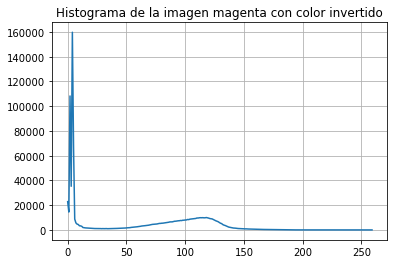

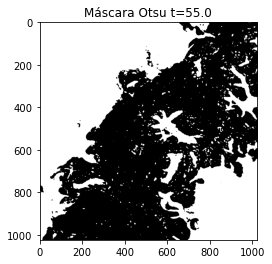

In [4]:
# Aplicar un filtro gaussiano de tamaño 5x5 y después utilizar el método de Otsu de manera que
# los píxeles correspondientes al lumen y al background de la imagen sean 1s y el resto de los píxeles tengan un valor de 0.
# Nota: Recordar que el método de Otsu requiere como input una imagen en el rango [0-255] en formato "uint8".
# Visualizar la máscara resultante

# Pasamos la imagen normalizada del color magenta al rango [0-255] en formato 'uint8'
img_mag = np.float32(img_mag_p*255)
img_mag = img_mag.astype('uint8')

# Aplicamos un filtro gaussiano para emborronar las altas frecuencias
if verificacion: # Los resultados de la imagen de verificación son sin el filtro de Gauss
    img_mag_gaus = img_mag
else:
    img_mag_gaus = cv2.GaussianBlur(img_mag, (5,5), 0)

# Determinamos el histograma
hist = cv2.calcHist([img_mag_gaus], [0], None, [260], [0, 260]) # [0] son los canales, None la máscara
plt.plot(hist)
plt.grid()
plt.title('Histograma de la imagen magenta con color invertido')
plt.show()

# Aplicamos el método OTSU para la segmentación del lumen y el fondo
if verificacion:
    metodo=cv2.THRESH_OTSU
else:
    # Dado que queremos conservar el fondo (componente mayoritario del histograma), 
    # invertimos también el color de la imagen
    metodo=cv2.THRESH_OTSU + cv2.THRESH_BINARY_INV
    
t, mask = cv2.threshold(img_mag_gaus,0,1,metodo)

# Visualizamos 
plt.imshow(mask, cmap='gray')
plt.title('Máscara Otsu t=' + str(t))
plt.show()

#### 3) Limpiar la imagen eliminando los artefactos de lumen (objetos blancos pequeños que no son lúmenes)

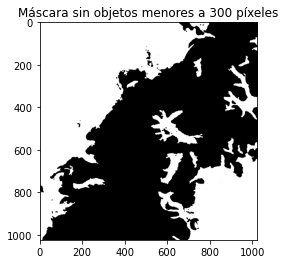

In [5]:
# Utilizar la librería skimage.morphology.remove_small_objects para eliminar aquellos objetos cuya área sea menor a 300 píxeles
# Más información en https://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.remove_small_objects
# Visualizar la máscara resultante
from skimage import morphology
mask_bool = mask.astype('bool')
mask_clean = morphology.remove_small_objects(mask_bool, min_size=300)

# Visualizamos 
plt.imshow(mask_clean, cmap='gray')
plt.title('Máscara sin objetos menores a 300 píxeles')
plt.show()

#### 4) Rellenar con 0s el fondo de la imagen para quedarnos únicamente con los lúmenes

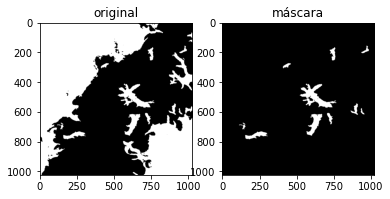

In [6]:
# Aplicar el algoritmo de expansión a partir de semillas (region growing) de manera que únicamente los lúmenes sean blancos
# y el resto de la imagen negra. Pista: utilizar dos semillas. Nota: Se pueden fijar las semillas de manera manual, pero
# se valorará positivamente a aquell@s que desarrollen una función para encontrarlas automáticamente.
# Visualizar la máscara resultante. 

# Creamos una copia de la imagen y editarmos su formato
img_lumen = mask_clean.copy()
img_lumen = img_lumen.astype('uint8')

# Definimos una imagen negra de referencia
h, w = mask_clean.shape
ref = np.zeros((h+2, w+2), np.uint8)

# Fijamos las semillas. 
# Recorremos el borde de la imagen y rellenamos aquellas partes en contacto con el borde
# Aunque pueden haber lúmenes en contacto con el borde, esto no nos interesan ya que su información
# no será completa, por lo que podría proporcionar resultados erróneos en el último paso de este ejercicio
for i in [0,h-1]:
    for j in range(w):
        cv2.floodFill(img_lumen, ref, (j,i), 0)          
for j in [0,w-1]:
    for i in range(1,h-1):
        cv2.floodFill(img_lumen, ref, (j,i), 0) 
        
# Visualizamos
fig, ax = plt.subplots(1,2)
ax[0].imshow(mask_clean, cmap='gray'), ax[0].set_title('original')
ax[1].imshow(img_lumen, cmap='gray'), ax[1].set_title('máscara')
plt.show()

#### 5) Rellenar los objetos de los lúmenes

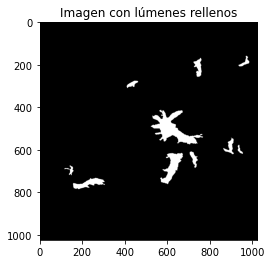

In [7]:
# Rellenar los lúmenes con la función binary_fill_holes de la librería scipy.ndimage.morphology
# Visualizar la máscara resultante
from scipy.ndimage.morphology import binary_fill_holes as bfh
img_lumen_filled = bfh(img_lumen.copy())

# Visualizamos
plt.imshow(img_lumen_filled, cmap='gray')
plt.title('Imagen con lúmenes rellenos')
plt.show()

#### 6) Detectar y dibujar los contornos de los lúmenes sobre la imagen original

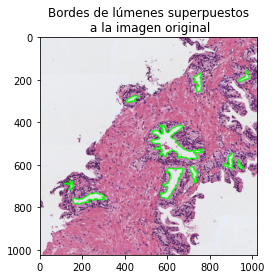

In [8]:
# Dibujar los contornos de los lúmenes en color verde sobre la imagen original RGB. Nota: Utilizar los flags necesarios
# para que los contornos en verde sean perfectamente visibles. 
# Visualizar la imagen superpuesta

bordes_RGB, hierarchy = cv2.findContours(image=img_lumen_filled.astype('uint8'), mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
img_RGB_lumen = img.copy()
cv2.drawContours(image=img_RGB_lumen, contours=bordes_RGB, contourIdx=-1, 
                 color=(0, 255, 0), thickness=4, lineType=cv2.LINE_AA)

# Visualizamos 
plt.imshow(img_RGB_lumen)
plt.title('Bordes de lúmenes superpuestos\n a la imagen original')
plt.show()


#### 7) Identificar y cropear el lumen más grande

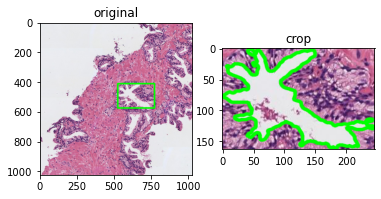

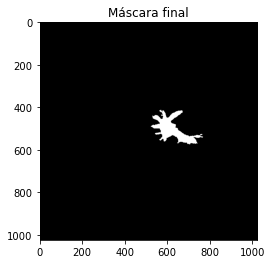

In [9]:
# Determinar cuál es el lumen de mayor área y hacer un crop del mismo sobre la imagen original RGB.
# Visualizar el lumen cropeado.

# Convertimos la imagen de lúmenes binaria en una imagen de etiquetas para tener acceso a cada objeto por separado
from skimage.measure import regionprops
from skimage.measure import label
lab, num = label(img_lumen_filled, return_num=True)

# Identificamos la etiqueta del objeto de mayor área
area_mayor = 0
objeto_mayor = 0
for i in range(1, num+1): 
    objeto = lab == i
    objeto = objeto.astype('uint8')
    prop = regionprops(objeto.astype(np.uint8))
    area = prop[0].area
    if area > area_mayor:
        area_mayor = area
        objeto_mayor = objeto

# Extraemos la bording box del lumen de mayor tamaño
prop = regionprops(objeto_mayor.astype(np.uint8)) 
bbox = prop[0].bbox
start_point = (bbox[1], bbox[0])
end_point = (bbox[3], bbox[2])
window = cv2.rectangle(img.copy(), start_point, end_point, (0, 255, 0), 10)

# Aplicamos cropping de la boarding box sobre la imagen original
lumen_crop = img_RGB_lumen[bbox[0]:bbox[2], bbox[1]:bbox[3]]

# Visualizamos
figs, ax = plt.subplots(1,2)
ax[0].imshow(window, cmap='gray'), ax[0].set_title('original')
ax[1].imshow(lumen_crop, cmap='gray'), ax[1].set_title('crop')
plt.show()

plt.imshow(objeto_mayor, cmap='gray')
plt.title('Máscara final')
plt.show()

#### 8) Extraer 13 características geométricas que permitan caracterizar el lumen recortado 

In [10]:
# Calcular las siguientes características del crop del lumen de mayor área, redondeando su valor hasta el cuarto decimal.
# 1) Área
# 2) Área de la bounding box
# 3) Área convexa
# 4) Exentricidad
# 5) Diámetro equivalente
# 6) Extensión
# 7) Diámetro Feret
# 8) Longitud del eje mayor
# 9) Longitud del eje menor
# 10) Orientación
# 11) Perímetro
# 12) Solidez
# 13) Compacidad

import pandas as pd
import math

# Asignamos las distintas variables a un diccionario
data = {} 
data['Area'] = np.round(prop[0].area, 4)
data['Bbox_area'] = np.round(prop[0].bbox_area, 4)
data['Convex_area'] = np.round(prop[0].convex_area, 4)
data['Eccentricity'] = np.round(prop[0].eccentricity, 4)
data['Equiv_diameter'] = np.round(prop[0].equivalent_diameter, 4)
data['Extent y rectangularity'] = np.round(prop[0].extent, 4)
data['Feret_diam'] = np.round(prop[0].feret_diameter_max, 4) 
data['Major_axis'] = np.round(prop[0].major_axis_length, 4)
data['Minor_axis'] = np.round(prop[0].minor_axis_length, 4)
data['Orientation'] = np.round(prop[0].orientation, 4)
data['Perimeter'] = np.round(prop[0].perimeter, 4)
data['Solidity'] = np.round(prop[0].solidity, 4)
data['Compactness'] = np.round(4*math.pi*prop[0].area/prop[0].perimeter**2, 4)

# Mostramos los resultados
display(pd.Series(data))

Area                       14075.0000
Bbox_area                  40098.0000
Convex_area                29283.0000
Eccentricity                   0.8478
Equiv_diameter               133.8688
Extent y rectangularity        0.3510
Feret_diam                   259.0772
Major_axis                   238.6358
Minor_axis                   126.5495
Orientation                    1.0058
Perimeter                   1242.5971
Solidity                       0.4807
Compactness                    0.1146
dtype: float64